# CSE 146 Lab 3: Algorithmic Fairness

### ASSIGNED: February 20, 2020
### DUE: March 3, 2020

In this homework, you will gain experience with tools for implementing classifiers that provide fairness guarantees. In part 2, you will try to get a fair classifier if you only have access to a normal classifier. In parts 3 and 4, you will get to explore the different outcomes when using different definitions of fairness for classifiers. You will also look at the tradeoffs between fairness and accuracy. 

All cells where code is required are marked with a "YOUR CODE HERE" comment. The point values for each code block are written in the header for the associated subsection.


## Instructions 
For each question, you should write python code to compute the answer to the questions that renders in a readable way according to the specifications of the question. You may only use the packages provided in the Background and Setup code. We will not be installing any packages during grading, and code that does not compile will negatively affect your grade.

This assignment is to be done <b>on your own</b>. You may discuss the assignment with your classmates, but do not share code or solutions. List the students you discussed the assignment with in the space provided below. You may visit any of the TAs in their office hours or ask questions on Piazza.

Be sure to rename this homework notebook so that it includes your last name. 

### List any students you talked with about this assignment here:
1. [person 1]
2. [person 2]
3. etc.

## Part 1: Importing Data (5 Points)
Before working with the algorithms for fair classification, we must first import the dataset we wish to use. We will again be working with the "Communities and Crime" dataset from [UC Irvine's Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/communities+and+crime). It includes data about the different types of crimes among various communities, socioeconomic and racial data about each community, and information about the police force in each community.

The algorithms will require that your data is split into 3 DataFrames:

- `dataX`: The features of each instance, not including any protected attributes
- `dataA`: The protected attributes of each instance
- `dataY`: The label for each instance

Currently, we provide you with 2 CSV files:

- `communities.csv`, which contains all information for each instance
- `communities_protected.csv`, which labels each column as 1 if the attribute is a protected feature, 2 if the attribute is the value to be predicted, and 0 otherwise. In part 2, we will focus on only one of the sensitive features. In parts 3 and 4, we will use all 18 sensitive features for upholding our fairness metrics.

Write code to generate the 3 Pandas DataFrames, `dataX`, `dataA` and `dataY`. 

In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import pandas as pd # Necessary libraries
import numpy as np
import warnings # Suppressing warnings
warnings.filterwarnings('ignore') 

In [33]:
df_comm = pd.read_csv("communities.csv")
df_comm_p = pd.read_csv("communities_protected.csv")

# dataX is the dataframe for communities.csv with columns dropped if column labels in communities_protected.csv is 1 or 2 (so only columns labels with value 0)

# dataA is the dataframe for communities.csv with columns dropped if column labels in communities_protected.csv is 0 or 2 (so only columns labels with value 1)

# and dataY is the dataframe for communities.csv with columns dropped if column labels in communities_protected.csv is 0 or 1 (so only columns labels with value 2)

x_cols = []
a_cols = []
y_cols = []

for col_name, col_data in df_comm_p.iteritems():
    v = col_data.values[0]

    if(v == 0): x_cols.append(col_name)
    if(v == 1): a_cols.append(col_name)
    if(v == 2): y_cols.append(col_name)

dataX = df_comm[x_cols]
dataA = df_comm[a_cols]
dataY = df_comm[y_cols]

In [34]:
print('dataX Shape:', dataX.shape)
print('dataA Shape:', dataA.shape)
print('dataY Shape:', dataY.shape)

dataX Shape: (1994, 104)
dataA Shape: (1994, 18)
dataY Shape: (1994, 1)


## Part 2: Two-Group Fairness via Post-processing (35 Points)

In this section, you will implement a method of achieving a fair classifier "from scratch" by post-processing a generic linear regression classifier. This method is described in depth in https://arxiv.org/abs/1610.02413. 

You will train a classifier which approximately equalizes both True Positive Rate and False Positive Rate for two groups, which is commonly referred to as the Equalized Odds criterion.

### 2.1: Training a Real-Valued Predictor (5 points)

Fairness postprocessing requires training a model which predicts real-valued scores (such as the estimated probability of a positive label) rather than just predicting 0 or 1. 

Use the Linear Regression package from SciKit-Learn to train a regression model on dataX and dataY. Generate predictions for dataY (called y_hat_score) and print them.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [35]:
from sklearn.linear_model import LinearRegression

X_train = dataX.iloc[0:1600, :]
X_test = dataX.iloc[1600:, :]
Y_train = dataY.iloc[:1600, :]
Y_test = dataY.iloc[1600:, :]

reg = LinearRegression().fit(X_train, Y_train)
y_hat_score = reg.predict(X_test)

In [36]:
print(y_hat_score)

[[-2.66686492e-01]
 [ 9.50559583e-01]
 [ 3.03987067e-01]
 [ 2.85658544e-01]
 [ 3.42498895e-01]
 [ 2.01933255e-01]
 [-1.23232701e-01]
 [ 8.32702197e-01]
 [ 2.03836382e-01]
 [-1.64765828e-02]
 [ 6.88966042e-01]
 [-4.47152291e-03]
 [ 1.12585658e+00]
 [-2.95537245e-01]
 [ 1.48270269e-01]
 [ 1.02958872e-01]
 [-8.99128812e-02]
 [ 4.77100305e-01]
 [ 9.27622958e-02]
 [ 9.02669472e-01]
 [ 2.69867119e-01]
 [ 1.32842942e-01]
 [ 1.56110096e-04]
 [ 5.03417123e-01]
 [ 1.92345825e-01]
 [ 1.00536386e+00]
 [ 5.13310340e-01]
 [-1.31165080e-01]
 [ 3.45663344e-01]
 [ 2.89864946e-02]
 [ 3.78486940e-02]
 [-1.97521187e-01]
 [ 7.57506966e-01]
 [ 1.13869423e+00]
 [ 6.96624348e-02]
 [ 1.37223578e-02]
 [ 5.55238642e-01]
 [ 3.12792336e-01]
 [ 3.54142892e-01]
 [-1.04092294e-01]
 [ 1.66621972e+11]
 [ 4.49057897e-01]
 [ 1.14210724e-02]
 [ 1.00431735e-01]
 [ 7.10197604e-02]
 [ 3.31129774e-01]
 [-8.44210880e-02]
 [ 4.36571422e-01]
 [ 1.49577007e-01]
 [ 2.05774110e-01]
 [ 7.87422414e-02]
 [ 2.00902887e-01]
 [-1.4396737

### 2.2: Binary Classification via Thresholding (5 points)

Write a function (threshold_predictions) which takes in a set of predicted scores and a threshold, and converts the scores to 0/1 predictions (below or equal to threshold = 0, above threshold = 1). Print out your converted predictions using a threshold of 0.5.

In [37]:
def threshold_predictions(y_hat_score, threshold):
    return [[ (0 if i<threshold else 1) for i in row] for row in y_hat_score]
    

In [38]:
y_hat_0_1 = threshold_predictions(y_hat_score, 0.5)
print(y_hat_0_1)

[[0], [1], [0], [0], [0], [0], [0], [1], [0], [0], [1], [0], [1], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [1], [0], [1], [1], [0], [0], [0], [0], [0], [1], [1], [0], [0], [1], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [1], [1], [0], [0], [0], [0], [0], [0], [1], [1], [0], [0], [0], [0], [0], [1], [1], [1], [0], [0], [0], [0], [0], [1], [0], [1], [0], [0], [0], [1], [0], [1], [0], [0], [0], [0], [0], [1], [1], [0], [0], [0], [1], [0], [0], [0], [1], [0], [0], [1], [1], [0], [0], [0], [0], [1], [0], [1], [0], [0], [1], [0], [0], [0], [0], [1], [1], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [1], [0], [1], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [1], [0], [0], [1], [0], [1], [0], [1], [1], [0], [0], [0], [0], [1], [0], [0], [0], [1], [1], [1], [1], [0], [1], [0], [0], [0], [0], [0], [0], [0],

### 2.3: Computing TPR and FPR (5 points)

There are many peformance measurements for machine learning classifiers. We now introduce two new ones, true positive rate and true negative rate. We define them using the terminology from a confusion matrix:

\begin{equation}
FalsePosRate = \frac{False Positive}{False Positive + True Negative}
\end{equation}

\begin{equation}
TruePosRate = \frac{True Positive}{True Positive + False Negative}
\end{equation}

Write functions which compute the true positive rate and false positive rate, given vectors for true labels (y) and binary predictions (y_hat). Then, compute the TPR and FPR for your predictions from 2.2.



In [39]:
def true_positive_rate(y, y_hat):
    TP = 0 # y=1, y_h=1
    FN = 0 # y=1, y_h=0

    for i in range(0, len(y)):
        a = y[i][0]
        b = y_hat[i][0]

        if(a==1 and b==1): TP+=1
        if(a==1 and b==0): FN+=1

    return TP/(TP+FN)


def false_positive_rate(y, y_hat):
    FP = 0 # y=0, y_h=1
    TN = 0 # y=0, y_h=0

    for i in range(0, len(y)):
        a = y[i][0]
        b = y_hat[i][0]

        if(a==0 and b==1): FP+=1
        if(a==0 and b==0): TN+=1

    return FP/(FP+TN)

In [40]:
print(true_positive_rate(Y_test.values, y_hat_0_1))
print(false_positive_rate(Y_test.values, y_hat_0_1))

0.6727272727272727
0.07394366197183098


### 2.4: Computing ROC Curves (5 points)

ROC (receiver operating characteristic) curves measure the tradeoff between true positive and false positive rates when thresholding a real-valued predictor. We discussed them in class, and this statquest video can be quite helpful: https://www.youtube.com/watch?v=4jRBRDbJemM

Write a function that:
- takes in a set of true labels in {0,1} (such as dataY), a set of predictions within interval [0,1] (such as y_hat_score), and a single integer `num_thresholds`, representing the number of thresholds. 
- Evenly divide the range [0,1] into `num_thresholds` equally sized intervals. (For example, if num_thresholds = 100, your thresholds should be 0.00, 0.01, 0.02, ... , 0.99.) 
- For each interval, using the bottom of the interval as a threshold,  compute the TPR and FPR of the thresholded predictions.

Then, using your function, compute TPR and FPR arrays for `dataY`, `y_hat_score` and `num_thresholds` at 100. (Hint: see numpy's `arange` function)

In [41]:
def compute_roc_curve(y, y_hat_score, num_thresholds):
    tpr = []
    fpr = []

    threshs = [round(i * (1 / num_thresholds), 3) for i in range(num_thresholds)]
    
    for t in threshs:
        tp = threshold_predictions(y_hat_score, t)
        tpr.append(round(true_positive_rate(y, tp), 5))
        fpr.append(round(false_positive_rate(y, tp), 5))

    # End of your code
    return tpr, fpr


In [42]:
tpr, fpr = compute_roc_curve(Y_test.values, y_hat_score, 100)

### 2.5: ROC Curve Comparison (5 points)

The code below is copied from our solution to Lab 1. It splits the data into two groups (A and B) based on whether the proportion of some attribute is greater than some threshold. We use it to split our data depending on whether the proportion of African American people in a community is greater than 50%. Run the cell below.

In [43]:
## RUN THIS CELL
## DO NOT MODIFY

def split_on_feature(dataX, dataY, dataA, column, thresh):
    rows_A = []
    rows_B = []
    for i in range(dataX.shape[0]):
        if dataA[i, column] < thresh:
            rows_A.append(i)
        else:
            rows_B.append(i)
    
    X_A = dataX[rows_A, :]
    X_B = dataX[rows_B, :]
    y_A = dataY[rows_A]
    y_B = dataY[rows_B]
    
    return X_A, X_B, y_A, y_B  


# change 2 to whatever racepctblack is
X_A, X_B, y_A, y_B = split_on_feature(dataX.values, dataY.values, dataA.values, 0, 0.5)

Using the generated arrays (X_A, X_B, y_A, y_B) and your function from 2.4, produce a matplotlib plot showing the ROC curves for each group with 100 threshold values. Use your trained linear regression model for predictions. Your X axis should be FPR and your Y axis should be TPR. Refer to Homework 1 for a reminder on how to use matplotlib.

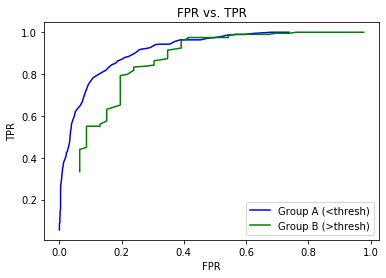

In [44]:
%matplotlib inline 
import matplotlib.pyplot as plt

A_y_hat_score = reg.predict(X_A)
A_tpr, A_fpr = compute_roc_curve(y_A, A_y_hat_score, 100)

B_y_hat_score = reg.predict(X_B)
B_tpr, B_fpr = compute_roc_curve(y_B, B_y_hat_score, 100)

plt.title('FPR vs. TPR')
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.plot(A_fpr, A_tpr, color='blue', label='Group A (<thresh)') # Group A
plt.plot(B_fpr, B_tpr, color='green', label='Group B (>thresh)') # Group B
plt.legend()

plt.show()

### 2.6: Minimizing Unfairness (5 points)

There are many, many different definitions of unfairness. For this lab, we'll be using the **Equalized Odds Criterion**, where we check if the ROC curves of two groups are the same. We check its "fairness error" via: $|TPR_A - TPR_B| + |FPR_A - FPR_B|$

There are 10,000 possible pairs of thresholds of the form $(a,b)$ where $a$ is the threshold for A and $b$ is the threshold for B in data plotted above. Find and print out the pair which minimizes this "fairness error". You can think of this as finding points which are closest between the two ROC curves.

In [45]:
min_fairness = float('inf')
min_unfairness_A_thresh = 0
min_unfairness_B_thresh = 0

A_y_hat_score = reg.predict(X_A)
B_y_hat_score = reg.predict(X_B)

for a in range(1,101):
    A_tpr, A_fpr = compute_roc_curve(y_A, A_y_hat_score, a)
    for b in range(1, 101):
        B_tpr, B_fpr = compute_roc_curve(y_B, B_y_hat_score, b)
        minl = min(len(A_tpr), len(A_fpr), len(B_tpr), len(B_fpr))
        for i in range(minl):
            fairness = abs(A_tpr[i]-B_tpr[i]) + abs(A_fpr[i]-B_fpr[i])
            if(fairness < min_fairness):
                min_fairness = fairness
                min_unfairness_A_thresh = a
                min_unfairness_B_thresh = b


In [46]:
print((min_unfairness_A_thresh, min_unfairness_B_thresh))

(95, 14)


### 2.7: Evaluating Accuracy (5 points)

Compute the overall accuracy when using the thresholds from 2.6 on their respective groups. Compare this to the threshold in {0.00, 0.01, 0.02, ... , 0.99} that gives us the highest accuracy for both groups.

In [47]:
A_tpr_1, A_fpr_1 = compute_roc_curve(y_A, A_y_hat_score, 95)
B_tpr_1, B_fpr_1 = compute_roc_curve(y_B, B_y_hat_score, 14)

fair_err = abs(sum(A_tpr_1)/len(A_tpr_1) - sum(B_tpr_1)/len(B_tpr_1))

y_hat_score = reg.predict(X_test)
tpr, fpr = compute_roc_curve(Y_test.values, y_hat_score, 100)

min_err = max(tpr)

In [48]:
print((min_err, fair_err))

(1.0, 0.3075988571428572)


## Part 3: Marginal Group Fairness via Cost-Sensitive Reduction (15 Points)

In this section, you will implement models from Microsoft Research (MSR), which use cost-sensitive classification in order to generate classifiers which satisfy particular fairness metrics. The algorithm is derived in [A Reductions Approach to Fair Classification](https://arxiv.org/pdf/1803.02453.pdf).

### 3.1: Importing the MSR code (5 Points)
The version of the MSR code has been provided in the same directory as this notebook. Run the following command to make sure that the notebook is able to run the code.

In [49]:
## Run this cell
!python test_fairlearn.py

import marginal_fair
## Expected Output:
# testing (DP, eps=0.100): ok

testing (DP, eps=0.100): disp_diff=-3.726620e-03


### 3.2: Marginal Fairness (5 Points)
In this section, you will analyze a classifier that is marginally fair with respect to the protected attributes.

The current implementation of the MSR code allows for one protected attribute at a time, so we have provided a file `marginal_fair.py` which generalizes the MSR code to allow for more than one protected attribute.

At the bottom of `marginal_fair.py`, you will find a function `run_eps_single`, which runs this algorithm. The function takes in 4 arguments: `eps`, `x`, `a`, and `y`. `x`, `a`, and `y` correspond to `dataX`, `dataA`, and `dataY`, respectively, and `eps` is a parameter which measures the allowed statistical unfairness of a classifier (in this case, we are looking at false positive disparity rates).

Using `run_eps_single`, get the predictions of the marginally fair classifier for `eps = 0.01` and report the overall error of this classifier.

In [50]:
## YOUR CODE HERE



### 3.3: Pareto Curve for Marginally Fair Classifier (5 Points)
By varying the parameter `eps`, construct a Pareto curve that measures the error of the classifier as the allowed fairness violation changes.

Use the following values for `eps`: `.005, .01, .075, .14, .2`

When the code is complete, plot your results using `matplotlib`.

In [51]:
## YOUR CODE HERE



## Part 4: Short Response Questions (25 Points)

**Question 1:** Below is a gif of a heatmap which shows how false positive disparity change for specific subgroups as the Learner and Auditor interact in each round. Each square represents a subgroup, the z-axis is the fairness disparity of that subgroup. What does it mean when the heatmap is \"flat\"?
![heatmap](./heatmap.gif)

When it is flat, ALL possible disparities from ALL possible pairs (of the x and y axis ) are minimal

**Question 2:** Look at the error and gamma unfairness in the MSR code. Can you think of any possible explanations?

... skip ...

**Question 3:** In Part 2, you should have seen that the error of the most fair pair of thresholds was much larger than the error for the best overall threshold. Suppose that you are allowed to randomize between thresholds, allowing you to achieve any TPR-FPR pair beneath the ROC curve for each group. Can you think of a better approach for maximizing accuracy while maintaining fairness?

To maximize accuracy and mantain fairness,  we should try to shoot for a point where the curve starts to change. This can be done with a dertivate. Basically calculate the maxium slope

**Question 4:** What do you think the relationship error of a fair classifier and the number of protected attributes is? That is, if we increase the number of protected attributes, do you think the error would increase, decrease, or stay the same?

The error would be directly tied to the number of protected features. As you increase the number pf protected fetures, there are less features you can train on -- thus increasing your overall error

**Question 5:** Do you think accuracy was a good measure to evaluate each thresholds in part 2.7? Why or why not?

Accuracy was a good way to evaulate the thresholds as this sort of data would benifit from a high TP and TN rate, rather than FP and FN